In [1]:
import os
from PIL import Image
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import itertools

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.efficientnet import EfficientNetB3

import warnings
warnings.filterwarnings("ignore")

In [2]:
def train_df(tr_path):
    classes = []
    class_paths = []
    files = os.listdir(tr_path)
    for file in files:
        label_dir = os.path.join(tr_path, file)
        label = os.listdir(label_dir)
        for image in label:
            image_path = os.path.join(label_dir, image)
            class_paths.append(image_path)
            classes.append(file)
    image_classes = pd.Series(classes, name='Class')
    image_paths = pd.Series(class_paths, name='Class Path')
    tr_df = pd.concat([image_paths, image_classes], axis=1)
    return tr_df

def test_df(test_path):
    classes = []
    class_paths = []
    files = os.listdir(test_path)
    for file in files:
        label_dir = os.path.join(test_path, file)
        label = os.listdir(label_dir)
        for image in label:
            image_path = os.path.join(label_dir, image)
            class_paths.append(image_path)
            classes.append(file)
    image_classes = pd.Series(classes, name='Class')
    image_paths = pd.Series(class_paths, name='Class Path')
    ts_df = pd.concat([image_paths, image_classes], axis=1)
    return ts_df

In [7]:
tr_df = train_df('skinCancerData/train')
ts_df = train_df('Skin Cancer Detect/skinCancerData/test')

In [10]:
valid_df, ts_df = train_test_split(ts_df,  train_size= 0.5, shuffle= True, random_state= 20)

In [9]:
batch_size = 16
img_size = (224, 224)
channels = 3
img_shape = (224, 224, 3)

gen = ImageDataGenerator()

tr_gen = gen.flow_from_dataframe(tr_df, x_col= 'Class Path', y_col= 'Class', target_size= img_size,
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

valid_gen = gen.flow_from_dataframe(valid_df, x_col= 'Class Path', y_col= 'Class', target_size= img_size,
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

ts_gen = gen.flow_from_dataframe(ts_df, x_col= 'Class Path', y_col= 'Class', target_size= img_size,
                                    color_mode= 'rgb', shuffle= False, batch_size= batch_size)

Found 2637 validated image filenames belonging to 2 classes.
Found 330 validated image filenames belonging to 2 classes.
Found 330 validated image filenames belonging to 2 classes.


In [11]:
g_dict = tr_gen.class_indices
classes = list(g_dict.keys())
images, labels = next(tr_gen)

plt.figure(figsize= (20, 20))

for i in range(16):
    plt.subplot(4, 4, i + 1)
    image = images[i] / 255
    plt.imshow(image)
    index = np.argmax(labels[i])
    class_name = classes[index]
    plt.title(class_name, color= 'blue', fontsize= 12)
    plt.axis('off')
plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [12]:
# Define the CNN model
cnn_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=img_shape),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(rate=0.4, seed=20),
    Dense(2, activation='softmax')
])

In [13]:
# Compile the CNN model
cnn_model.compile(Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Display the summary of the CNN model
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 26, 26, 128)       0

In [17]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

# Train the CNN model
history_cnn = cnn_model.fit(x=tr_gen, epochs=25, verbose=1, validation_data=valid_gen, validation_steps=None, callbacks=EarlyStopping(monitor='val_loss'))

Epoch 1/25
165/165 [==============================] - 598s 4s/step - loss: 35.7481 - accuracy: 0.7042 - val_loss: 0.4271 - val_accuracy: 0.8061
Epoch 2/25
165/165 [==============================] - 350s 2s/step - loss: 0.4563 - accuracy: 0.7819 - val_loss: 0.4076 - val_accuracy: 0.8091
Epoch 3/25
165/165 [==============================] - 328s 2s/step - loss: 0.3955 - accuracy: 0.8108 - val_loss: 0.3923 - val_accuracy: 0.8030
Epoch 4/25
165/165 [==============================] - 337s 2s/step - loss: 0.3594 - accuracy: 0.8286 - val_loss: 0.3558 - val_accuracy: 0.8333
Epoch 5/25
165/165 [==============================] - 335s 2s/step - loss: 0.3326 - accuracy: 0.8536 - val_loss: 0.3501 - val_accuracy: 0.8212
Epoch 6/25
165/165 [==============================] - 336s 2s/step - loss: 0.2899 - accuracy: 0.8684 - val_loss: 0.3421 - val_accuracy: 0.8242
Epoch 7/25
165/165 [==============================] - 328s 2s/step - loss: 0.3128 - accuracy: 0.8612 - val_loss: 0.4215 - val_accuracy: 0.793

In [18]:
# Evaluate the CNN model
train_score_cnn = cnn_model.evaluate(tr_gen, verbose=1)
valid_score_cnn = cnn_model.evaluate(valid_gen, verbose=1)
test_score_cnn = cnn_model.evaluate(ts_gen, verbose=1)

21/21 [==============================] - 128s 6s/step - loss: 0.5565 - accuracy: 0.7879


In [19]:
# Print the evaluation scores for CNN
print("CNN Train Loss: ", train_score_cnn[0])
print("CNN Train Accuracy: ", train_score_cnn[1])
print('-' * 20)
print("CNN Validation Loss: ", valid_score_cnn[0])
print("CNN Validation Accuracy: ", valid_score_cnn[1])
print('-' * 20)
print("CNN Test Loss: ", test_score_cnn[0])
print("CNN Test Accuracy: ", test_score_cnn[1])

CNN Train Loss:  0.2905944883823395
CNN Train Accuracy:  0.8816837072372437
--------------------
CNN Validation Loss:  0.42152145504951477
CNN Validation Accuracy:  0.7939394116401672
--------------------
CNN Test Loss:  0.5564860105514526
CNN Test Accuracy:  0.7878788113594055


In [20]:
# Define the EfficientNetB3 model
base_model = EfficientNetB3(include_top=False, weights="imagenet", input_shape=img_shape, pooling='max')

model = Sequential([
    base_model,
    Dense(256, activation='relu'),
    Dropout(rate=0.40, seed=20),
    Dense(2, activation='softmax')
])
# Freeze layers of EfficientNetB3
for layer in base_model.layers[:-4]:
    layer.trainable = False

43941136/43941136 [==============================] - 0s 0us/step


In [21]:
# Compile the EfficientNetB3 model
model.compile(Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Display the summary of the EfficientNetB3 model
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb3 (Functional  (None, 1536)              10783535  
 )                                                               
                                                                 
 dense_2 (Dense)             (None, 256)               393472    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 2)                 514       
                                                                 
Total params: 11177521 (42.64 MB)
Trainable params: 986882 (3.76 MB)
Non-trainable params: 10190639 (38.87 MB)
_________________________________________________________________


In [22]:
# Train the EfficientNetB3 model
history_efficientnetb3 = model.fit(x=tr_gen, epochs=25, verbose=1, validation_data=valid_gen, validation_steps=None, callbacks=EarlyStopping(monitor='val_loss'))

Epoch 1/25
165/165 [==============================] - 405s 2s/step - loss: 1.3034 - accuracy: 0.7664 - val_loss: 0.3728 - val_accuracy: 0.8212
Epoch 2/25
165/165 [==============================] - 422s 3s/step - loss: 0.4048 - accuracy: 0.8195 - val_loss: 0.3273 - val_accuracy: 0.8576
Epoch 3/25
165/165 [==============================] - 380s 2s/step - loss: 0.3581 - accuracy: 0.8426 - val_loss: 0.3378 - val_accuracy: 0.8606


In [23]:
# Evaluate the EfficientNetB3 model
train_score_efficientnetb3 = model.evaluate(tr_gen, verbose=1)
valid_score_efficientnetb3 = model.evaluate(valid_gen, verbose=1)
test_score_efficientnetb3 = model.evaluate(ts_gen, verbose=1)

21/21 [==============================] - 42s 2s/step - loss: 0.3515 - accuracy: 0.8333


In [24]:
# Print the evaluation scores for EfficientNetB3
print("EfficientNetB3 Train Loss: ", train_score_efficientnetb3[0])
print("EfficientNetB3 Train Accuracy: ", train_score_efficientnetb3[1])
print('-' * 20)
print("EfficientNetB3 Validation Loss: ", valid_score_efficientnetb3[0])
print("EfficientNetB3 Validation Accuracy: ", valid_score_efficientnetb3[1])
print('-' * 20)
print("EfficientNetB3 Test Loss: ", test_score_efficientnetb3[0])
print("EfficientNetB3 Test Accuracy: ", test_score_efficientnetb3[1])

EfficientNetB3 Train Loss:  0.25710639357566833
EfficientNetB3 Train Accuracy:  0.8877512216567993
--------------------
EfficientNetB3 Validation Loss:  0.3377724289894104
EfficientNetB3 Validation Accuracy:  0.8606060743331909
--------------------
EfficientNetB3 Test Loss:  0.3514803946018219
EfficientNetB3 Test Accuracy:  0.8333333134651184


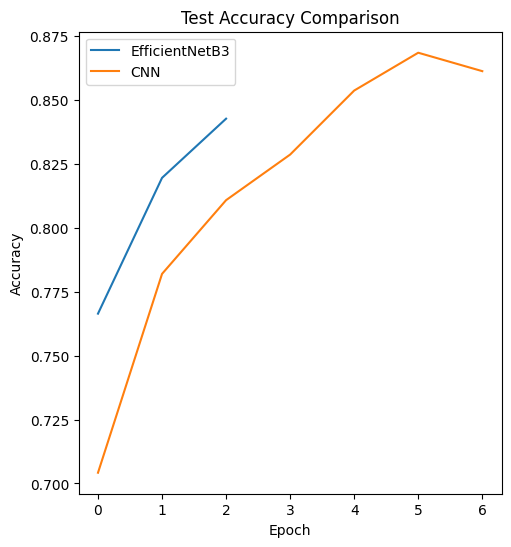

In [25]:
# Plotting the comparison
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history_efficientnetb3.history['accuracy'], label='EfficientNetB3')
plt.plot(history_cnn.history['accuracy'], label='CNN')
plt.title('Test Accuracy Comparison')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

In [27]:
from keras.models import load_model
model.save("skin_cancer_network.h5")
model.save("skin_cancer_network.keras")